In [1]:
#import
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#Defining base directory
base_dir = "/Users/kelly/Downloads/iLab-Capstone/data/WESAD"

subjects = ["S2","S3","S4","S5","S6","S7","S8","S9",
            "S10","S11","S13","S14","S15","S16","S17"]

target_hz = 4

for sid in subjects:
    p = os.path.join(base_dir, sid, f"{sid}.pkl")
    print(f"{sid}: {'OK' if os.path.exists(p) else 'MISSING'}  ->  {p}")

S2: OK  ->  /Users/kelly/Downloads/iLab-Capstone/data/WESAD/S2/S2.pkl
S3: OK  ->  /Users/kelly/Downloads/iLab-Capstone/data/WESAD/S3/S3.pkl
S4: OK  ->  /Users/kelly/Downloads/iLab-Capstone/data/WESAD/S4/S4.pkl
S5: OK  ->  /Users/kelly/Downloads/iLab-Capstone/data/WESAD/S5/S5.pkl
S6: OK  ->  /Users/kelly/Downloads/iLab-Capstone/data/WESAD/S6/S6.pkl
S7: OK  ->  /Users/kelly/Downloads/iLab-Capstone/data/WESAD/S7/S7.pkl
S8: OK  ->  /Users/kelly/Downloads/iLab-Capstone/data/WESAD/S8/S8.pkl
S9: OK  ->  /Users/kelly/Downloads/iLab-Capstone/data/WESAD/S9/S9.pkl
S10: OK  ->  /Users/kelly/Downloads/iLab-Capstone/data/WESAD/S10/S10.pkl
S11: OK  ->  /Users/kelly/Downloads/iLab-Capstone/data/WESAD/S11/S11.pkl
S13: OK  ->  /Users/kelly/Downloads/iLab-Capstone/data/WESAD/S13/S13.pkl
S14: OK  ->  /Users/kelly/Downloads/iLab-Capstone/data/WESAD/S14/S14.pkl
S15: OK  ->  /Users/kelly/Downloads/iLab-Capstone/data/WESAD/S15/S15.pkl
S16: OK  ->  /Users/kelly/Downloads/iLab-Capstone/data/WESAD/S16/S16.pkl
S1

In [3]:
def safe_get_signal(entry):
    """Return np.ndarray for either dict-with-'signal' or raw array/list."""
    if isinstance(entry, dict) and "signal" in entry:
        return np.asarray(entry["signal"])
    return np.asarray(entry)

def to_series(arr, name):
    """Flatten to 1-D Series with a RangeIndex (we'll attach time later)."""
    return pd.Series(np.asarray(arr).squeeze(), name=name)

def seconds_index(n, fs):
    """Create a time index in seconds for n samples at sampling rate fs."""
    return pd.to_timedelta(np.arange(n) / float(fs), unit="s")

def extract_chest_df(data):
    ch = data["signal"]["chest"]
    # read with shape-proof helper and flatten
    C_RESP = to_series(safe_get_signal(ch["Resp"]), "C_RESP")
    C_ECG  = to_series(safe_get_signal(ch["ECG"]) , "C_ECG")
    C_EDA  = to_series(safe_get_signal(ch["EDA"]) , "C_EDA")
    C_EMG  = to_series(safe_get_signal(ch["EMG"]) , "C_EMG")
    # Temp key casing varies; handle both
    temp_key = "Temp" if "Temp" in ch else ("TEMP" if "TEMP" in ch else None)
    C_TEMP = to_series(safe_get_signal(ch[temp_key]), "C_TEMP") if temp_key else None

    # Chest native fs ~700 Hz (use 700 if not present)
    fs = ch["Resp"].get("sampling_rate", 700) if isinstance(ch["Resp"], dict) else 700
    # build DataFrame with a proper time index (seconds)
    cols = [C_RESP, C_ECG, C_EDA, C_EMG] + ([C_TEMP] if C_TEMP is not None else [])
    chest = pd.concat(cols, axis=1)
    chest.index = seconds_index(len(chest), fs)
    return chest

def extract_wrist_df(data):
    wr = data["signal"]["wrist"]

    W_BVP  = to_series(safe_get_signal(wr["BVP"]), "W_BVP")
    W_EDA  = to_series(safe_get_signal(wr["EDA"]), "W_EDA")
    temp_key = "TEMP" if "TEMP" in wr else ("Temp" if "Temp" in wr else None)
    W_TEMP = to_series(safe_get_signal(wr[temp_key]), "W_TEMP") if temp_key else None

    # ACC can be (n,3), (3,n), (n,1*3) … normalize to 3 separate 1-D series
    acc = safe_get_signal(wr["ACC"])
    acc = np.squeeze(acc)
    if acc.ndim == 2:
        if acc.shape[0] == 3 and acc.shape[1] != 3:
            acc = acc.T
        if acc.shape[1] >= 3:
            W_ACC_X = to_series(acc[:,0], "W_ACC_X")
            W_ACC_Y = to_series(acc[:,1], "W_ACC_Y")
            W_ACC_Z = to_series(acc[:,2], "W_ACC_Z")
        else:
            # unusual; fall back to single column
            W_ACC_X = to_series(acc.reshape(-1), "W_ACC_X")
            W_ACC_Y = W_ACC_Z = None
    elif acc.ndim == 1 and acc.size % 3 == 0:
        acc = acc.reshape(-1, 3)
        W_ACC_X = to_series(acc[:,0], "W_ACC_X")
        W_ACC_Y = to_series(acc[:,1], "W_ACC_Y")
        W_ACC_Z = to_series(acc[:,2], "W_ACC_Z")
    else:
        W_ACC_X = to_series(acc.reshape(-1), "W_ACC_X")
        W_ACC_Y = W_ACC_Z = None

    # Wrist fs ~64 Hz; if present, use it from any channel
    fs = 64
    for k in ("BVP","EDA","TEMP","Temp","ACC"):
        if k in wr and isinstance(wr[k], dict) and "sampling_rate" in wr[k]:
            fs = wr[k]["sampling_rate"]; break

    cols = [W_BVP, W_EDA] + ([W_TEMP] if W_TEMP is not None else []) + \
           [W_ACC_X] + ([W_ACC_Y] if W_ACC_Y is not None else []) + ([W_ACC_Z] if W_ACC_Z is not None else [])
    wrist = pd.concat(cols, axis=1)
    wrist.index = seconds_index(len(wrist), fs)
    return wrist

def labels_series(data, fs_guess=700):
    y = np.asarray(data["label"]).squeeze()
    s = to_series(y, "Label")
    s.index = seconds_index(len(s), fs_guess)  # align roughly to chest clock
    return s.astype(int)

def resample_to(df, hz):
    """Downsample any time-indexed DF to target Hz using mean aggregation."""
    # ensure TimedeltaIndex then resample
    df = df.copy()
    df = df.resample(pd.to_timedelta(1/hz, unit="s")).mean()
    return df

def resample_labels(y, hz):
    """Downsample labels to target Hz using mode aggregation."""
    y = y.copy()
    y = y.resample(pd.to_timedelta(1/hz, unit="s")).agg(
        lambda x: x.mode().iat[0] if not x.mode().empty else np.nan
    )
    return y.astype(int)

def load_subject_4hz(subject_id):
    pkl_path = os.path.join(base_dir, subject_id, f"{subject_id}.pkl")
    with open(pkl_path, "rb") as f:
        data = pickle.load(f, encoding="latin1")

    chest = extract_chest_df(data)
    wrist = extract_wrist_df(data)
    y     = labels_series(data, fs_guess=700)     # labels aligned to chest clock

    # resample everything to the same 4 Hz grid
    chest_4 = resample_to(chest, target_hz)
    wrist_4 = resample_to(wrist, target_hz)
    y_4     = resample_labels(y.to_frame(), target_hz)

    # inner-join on common timestamps to guarantee equal lengths
    df4 = chest_4.join(wrist_4, how="inner").join(y_4, how="inner")
    df4["subject_id"] = subject_id
    return df4

#  LOAD ALL SUBJECTS 
dfs = []
for sid in subjects:
    try:
        df4 = load_subject_4hz(sid)
        print(f"✔ {sid}: {df4.shape}")
        dfs.append(df4)
    except Exception as e:
        print(f"✖ {sid}: {type(e).__name__} — {e}")

if not dfs:
    raise RuntimeError("No subjects loaded — check BASE_DIR or error messages above.")

combined_df = pd.concat(dfs, ignore_index=True)
print("Combined shape:", combined_df.shape)
combined_df.head()

✔ S2: (24316, 13)
✔ S3: (25972, 13)
✔ S4: (25692, 13)
✔ S5: (25032, 13)
✔ S6: (28284, 13)
✔ S7: (20952, 13)
✔ S8: (21864, 13)
✔ S9: (20892, 13)
✔ S10: (21984, 13)
✔ S11: (20932, 13)
✔ S13: (22148, 13)
✔ S14: (22192, 13)
✔ S15: (21008, 13)
✔ S16: (22524, 13)
✔ S17: (23680, 13)
Combined shape: (347472, 13)


,C_RESP,C_ECG,C_EDA,C_EMG,C_TEMP,W_BVP,W_EDA,W_TEMP,W_ACC_X,W_ACC_Y,W_ACC_Z,Label,subject_id
0,-1.175258,0.099215,5.250514,-0.003072,30.130919,6.269375,1.105996,35.410,57.7500,15.5625,21.875,0,S2
1,-0.849400,-0.144645,5.245671,-0.001752,30.123537,45.905000,1.176838,35.420,46.6250,11.5625,37.875,0,S2
2,-0.449097,0.033754,5.242846,-0.002758,30.122858,54.358750,1.085223,35.435,58.2500,19.0000,19.125,0,S2
3,-0.295279,0.067728,5.240734,-0.001257,30.117262,21.695625,1.119098,35.420,53.2500,16.6250,30.000,0,S2
4,-0.222866,-0.187926,5.257104,-0.003136,30.109482,-209.836875,1.284150,35.440,54.0625,23.2500,20.750,0,S2


In [4]:
combined_df['Label'].unique()

array([0, 1, 2, 6, 4, 3, 7, 5])

In [5]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install optuna

Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install ipywidgets

Note: you may need to restart the kernel to use updated packages.


In [8]:
#Import for modelling
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, f1_score
from sklearn.ensemble import RandomForestClassifier
import optuna

In [9]:
#Copy dataset
df = combined_df.copy()
df["Label"] = df["Label"].astype(int)

# feature groups
FEATURES   = [c for c in df.columns if c not in ("Label","subject_id")]
WRIST_COLS = [c for c in df.columns if str(c).startswith("W_")]
CHEST_COLS = [c for c in df.columns if str(c).startswith("C_")]

# masks
m3 = df["Label"].isin([1,2,3]).values         # multiclass (1,2,3)
mb = df["Label"].isin([1,2,3]).values         # binary uses same rows

# labels
y3 = df.loc[m3, "Label"].to_numpy(int)
g3 = df.loc[m3, "subject_id"].to_numpy(str)
yb = (df.loc[mb, "Label"].to_numpy() == 2).astype(int)
gb = df.loc[mb, "subject_id"].to_numpy(str)

#FULL features
X3_full = df.loc[m3, FEATURES].to_numpy(float)
Xb_full = df.loc[mb, FEATURES].to_numpy(float)

#WRIST-only
X3_wrist = df.loc[m3, WRIST_COLS].to_numpy(float)
Xb_wrist = df.loc[mb, WRIST_COLS].to_numpy(float)

#CHEST-only
X3_chest = df.loc[m3, CHEST_COLS].to_numpy(float)
Xb_chest = df.loc[mb, CHEST_COLS].to_numpy(float)

In [12]:
# Helpers
def loso_f1_rf(params, X, y, g, average):
    logo = LeaveOneGroupOut()
    f1s = []
    for tr, te in logo.split(X, y, g):
        clf = RandomForestClassifier(
            random_state=42,
            n_estimators=int(params["n_estimators"]),
            max_depth=params["max_depth"],
            max_features=params["max_features"],
            min_samples_split=int(params["min_samples_split"]),
            min_samples_leaf=int(params["min_samples_leaf"]),
            bootstrap=params["bootstrap"],
            class_weight="balanced",     
            n_jobs=-1,
        )
        clf.fit(X[tr], y[tr])
        f1s.append(f1_score(y[te], clf.predict(X[te]), average=average))
    return float(np.mean(f1s))

def make_rf_objective(X, y, g, average):
    def _obj(trial):
        params = {
            "n_estimators":      trial.suggest_int("n_estimators", 100, 300, step=50),
            "max_depth":         trial.suggest_categorical("max_depth", [None, 12, 20]),
            "max_features":      trial.suggest_categorical("max_features", ["sqrt", "log2"]),
            "min_samples_split": trial.suggest_int("min_samples_split", 2, 16),
            "min_samples_leaf":  trial.suggest_int("min_samples_leaf", 1, 6),
            "bootstrap":         True,                                  # fixed
            "max_samples":       trial.suggest_float("max_samples", 0.6, 0.9),
        }
        # inside scorer we’ll add class_weight="balanced"
        return loso_f1_rf(params, X, y, g, average)
    return _obj

def fit_best_rf(X, y, g, average, study_name="rf_study", n_trials=15):
    study = optuna.create_study(direction="maximize", study_name=study_name)
    study.optimize(make_rf_objective(X, y, g, average), n_trials=n_trials)
    bp = study.best_params  # already valid for RF

    rows, y_true_all, y_pred_all = [], [], []
    logo = LeaveOneGroupOut()
    for tr, te in logo.split(X, y, g):
        m = RandomForestClassifier(
            **bp,
            class_weight="balanced",
            n_jobs=-1,
            random_state=42
        )
        m.fit(X[tr], y[tr])
        yp = m.predict(X[te])
        y_true_all.extend(y[te]); y_pred_all.extend(yp)
        pr, rc, f1, _ = precision_recall_fscore_support(y[te], yp, average=average, zero_division=0)
        rows.append({"subject": g[te][0], "accuracy": accuracy_score(y[te], yp),
                     "precision": pr, "recall": rc, "f1": f1})

    per_subject = pd.DataFrame(rows).sort_values("subject")
    summary = per_subject[["accuracy","precision","recall","f1"]].mean().to_dict()
    cm = confusion_matrix(y_true_all, y_pred_all)
    return study.best_params, per_subject, summary, cm

    # final LOSO eval
    logo = LeaveOneGroupOut()
    rows, y_true_all, y_pred_all = [], [], []
    for tr, te in logo.split(X, y, g):
        m = RandomForestClassifier(**best.get_params())
        m.fit(X[tr], y[tr])
        yp = m.predict(X[te])
        y_true_all.extend(y[te]); y_pred_all.extend(yp)
        acc = accuracy_score(y[te], yp)
        pr, rc, f1, _ = precision_recall_fscore_support(y[te], yp, average=average, zero_division=0)
        rows.append({"subject": g[te][0], "accuracy": acc, "precision": pr, "recall": rc, "f1": f1})
    per_subject = pd.DataFrame(rows).sort_values("subject")
    summary = per_subject[["accuracy","precision","recall","f1"]].mean().to_dict()
    cm = confusion_matrix(y_true_all, y_pred_all)
    return best, study.best_params, per_subject, summary, cm

In [13]:
# Multiclass
bp_full_m,  ps_full_m,  sm_full_m,  cm_full_m  = fit_best_rf(X3_full,  y3, g3, "macro",  "rf_full_multiclass")
bp_wrist_m, ps_wrist_m, sm_wrist_m, cm_wrist_m = fit_best_rf(X3_wrist, y3, g3, "macro",  "rf_wrist_multiclass")
bp_chest_m, ps_chest_m, sm_chest_m, cm_chest_m = fit_best_rf(X3_chest, y3, g3, "macro",  "rf_chest_multiclass")

# Binary
bp_full_b,  ps_full_b,  sm_full_b,  cm_full_b  = fit_best_rf(Xb_full,  yb, gb, "binary", "rf_full_binary")
bp_wrist_b, ps_wrist_b, sm_wrist_b, cm_wrist_b = fit_best_rf(Xb_wrist, yb, gb, "binary", "rf_wrist_binary")
bp_chest_b, ps_chest_b, sm_chest_b, cm_chest_b = fit_best_rf(Xb_chest, yb, gb, "binary", "rf_chest_binary")

[I 2025-09-15 17:52:31,210] A new study created in memory with name: rf_full_multiclass
[I 2025-09-15 17:53:20,412] Trial 0 finished with value: 0.413807270012172 and parameters: {'n_estimators': 100, 'max_depth': 12, 'max_features': 'log2', 'min_samples_split': 12, 'min_samples_leaf': 2, 'max_samples': 0.7842767707515897}. Best is trial 0 with value: 0.413807270012172.
[I 2025-09-15 17:55:06,229] Trial 1 finished with value: 0.4293379225250537 and parameters: {'n_estimators': 200, 'max_depth': 12, 'max_features': 'log2', 'min_samples_split': 7, 'min_samples_leaf': 6, 'max_samples': 0.7430758481052215}. Best is trial 1 with value: 0.4293379225250537.
[I 2025-09-15 17:58:19,190] Trial 2 finished with value: 0.4495268574443397 and parameters: {'n_estimators': 300, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_samples': 0.7028203201650287}. Best is trial 2 with value: 0.4495268574443397.
[I 2025-09-15 17:59:45,572] Trial 3 finished with value


=== RF Full (Multiclass) ===
Subject-macro: {'accuracy': 0.584, 'precision': 0.4773, 'recall': 0.4707, 'f1': 0.4411}
Pooled/micro: {'accuracy': np.float64(0.5841), 'precision': np.float64(0.5841), 'recall': np.float64(0.5841), 'f1': np.float64(0.5841)}
Top-5 subjects:
   subject  accuracy  precision    recall        f1
4     S15  0.879870   0.888103  0.767938  0.787008
2     S13  0.837152   0.751248  0.733990  0.719535
9      S4  0.776443   0.585621  0.607874  0.588296
3     S14  0.762236   0.759893  0.657082  0.681720
8      S3  0.636427   0.558380  0.553833  0.535061


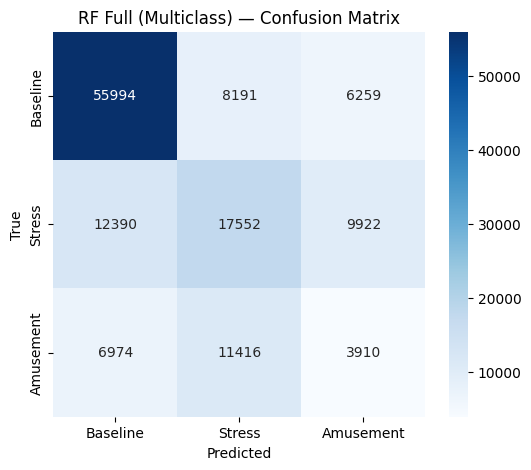


=== RF Wrist (Multiclass) ===
Subject-macro: {'accuracy': 0.6413, 'precision': 0.5447, 'recall': 0.5589, 'f1': 0.5369}
Pooled/micro: {'accuracy': np.float64(0.6415), 'precision': np.float64(0.6415), 'recall': np.float64(0.6415), 'f1': np.float64(0.6415)}
Top-5 subjects:
    subject  accuracy  precision    recall        f1
2      S13  0.737421   0.647795  0.628313  0.635348
10      S5  0.734326   0.535186  0.582197  0.556017
9       S4  0.727021   0.508485  0.569250  0.536540
12      S7  0.724522   0.737804  0.695820  0.679302
13      S8  0.702014   0.568696  0.553440  0.555545


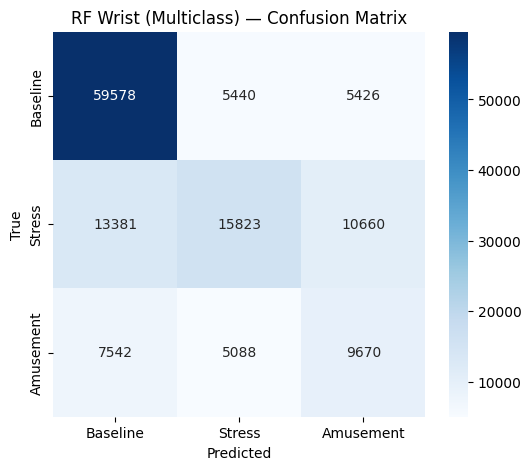


=== RF Chest (Multiclass) ===
Subject-macro: {'accuracy': 0.5263, 'precision': 0.4473, 'recall': 0.4638, 'f1': 0.3926}
Pooled/micro: {'accuracy': np.float64(0.5265), 'precision': np.float64(0.5265), 'recall': np.float64(0.5265), 'f1': np.float64(0.5265)}
Top-5 subjects:
    subject  accuracy  precision    recall        f1
4      S15  0.823556   0.541040  0.660426  0.593453
1      S11  0.728344   0.843027  0.823571  0.780581
2      S13  0.703167   0.633038  0.576352  0.575481
11      S6  0.646912   0.503068  0.552119  0.489110
5      S16  0.642278   0.565744  0.525704  0.543826


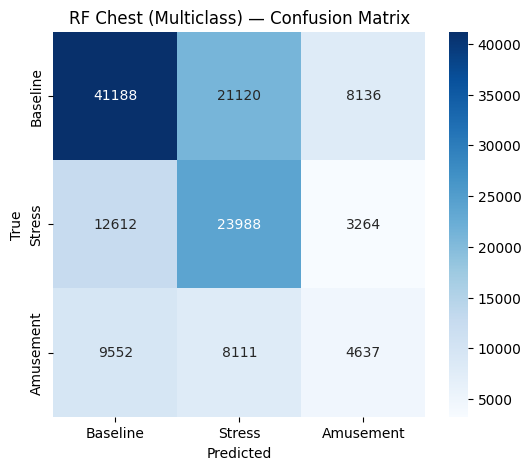


=== RF Full (Binary) ===
Subject-macro: {'accuracy': 0.6639, 'precision': 0.3696, 'recall': 0.3535, 'f1': 0.3202}
Pooled/micro: {'accuracy': np.float64(0.6648), 'precision': np.float64(0.43), 'recall': np.float64(0.3539), 'f1': np.float64(0.3883)}
Top-5 subjects:
    subject  accuracy  precision    recall        f1
4      S15  0.990596   1.000000  0.969388  0.984456
2      S13  0.894429   0.739130  0.998494  0.849455
13      S8  0.801381   0.800911  0.459328  0.583827
6      S17  0.759996   1.000000  0.244467  0.392887
9       S4  0.706697   0.000000  0.000000  0.000000


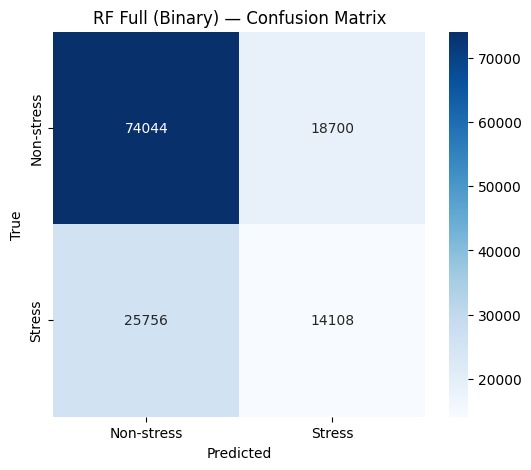


=== RF Wrist (Binary) ===
Subject-macro: {'accuracy': 0.7447, 'precision': 0.5208, 'recall': 0.5948, 'f1': 0.5525}
Pooled/micro: {'accuracy': np.float64(0.7464), 'precision': np.float64(0.5747), 'recall': np.float64(0.601), 'f1': np.float64(0.5876)}
Top-5 subjects:
    subject  accuracy  precision    recall        f1
12      S7  0.992038   0.975917  0.997266  0.986476
2      S13  0.972934   0.917387  0.999247  0.956569
13      S8  0.971367   0.913740  1.000000  0.954926
10      S5  0.954105   0.863743  1.000000  0.926891
0      S10  0.952130   0.869305  1.000000  0.930083


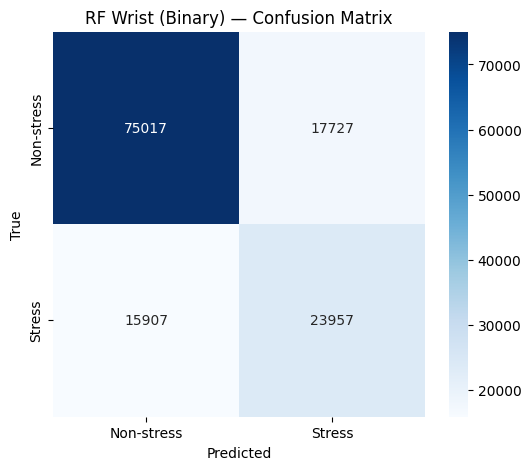


=== RF Chest (Binary) ===
Subject-macro: {'accuracy': 0.6308, 'precision': 0.4318, 'recall': 0.5687, 'f1': 0.4277}
Pooled/micro: {'accuracy': np.float64(0.6303), 'precision': np.float64(0.4165), 'recall': np.float64(0.5728), 'f1': np.float64(0.4823)}
Top-5 subjects:
    subject  accuracy  precision    recall        f1
4      S15  0.972906   0.918955  1.000000  0.957766
5      S16  0.963417   1.000000  0.879272  0.935758
2      S13  0.751235   0.570335  0.673193  0.617510
8       S3  0.749188   1.000000  0.155469  0.269101
14      S9  0.727242   0.528965  0.647674  0.582331


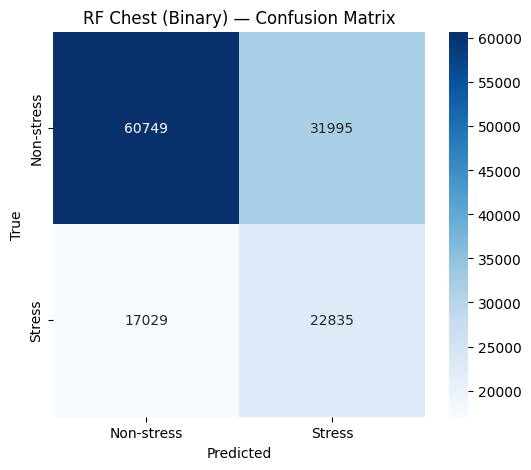

In [16]:
#performance metrics and confusion matrix
def plot_cm(cm, labels, title="Confusion Matrix"):
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=labels,
        yticklabels=labels
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.show()

def show_result(name, per_sub, summary, cm, labels):
    print(f"\n=== {name} ===")
    print("Subject-macro:", {k: round(v,4) for k,v in summary.items()})
    # pooled/micro:
    total = cm.sum(); acc = cm.trace()/total
    if len(labels) == 3:
        pooled = {"accuracy": acc, "precision": acc, "recall": acc, "f1": acc}
    else:
        tn, fp, fn, tp = cm.ravel()
        prec = tp/(tp+fp) if (tp+fp) else 0.0
        rec  = tp/(tp+fn) if (tp+fn) else 0.0
        f1   = 2*prec*rec/(prec+rec) if (prec+rec) else 0.0
        pooled = {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1}
    print("Pooled/micro:", {k: round(v,4) for k,v in pooled.items()})
    print("Top-5 subjects:\n", per_sub.sort_values("accuracy", ascending=False).head(5))
    plot_cm(cm, labels, f"{name} — Confusion Matrix")

labels_mc = ["Baseline","Stress","Amusement"]
labels_bi = ["Non-stress","Stress"]

# MULTICLASS
show_result("RF Full (Multiclass)", ps_full_m, sm_full_m, cm_full_m, labels_mc)
show_result("RF Wrist (Multiclass)", ps_wrist_m, sm_wrist_m, cm_wrist_m, labels_mc)
show_result("RF Chest (Multiclass)", ps_chest_m, sm_chest_m, cm_chest_m, labels_mc)

# BINARY
show_result("RF Full (Binary)", ps_full_b, sm_full_b, cm_full_b, labels_bi)
show_result("RF Wrist (Binary)", ps_wrist_b, sm_wrist_b, cm_wrist_b, labels_bi)
show_result("RF Chest (Binary)", ps_chest_b, sm_chest_b, cm_chest_b, labels_bi)

In [18]:
#Feature importance
def mean_importances_over_loso_rf(X, y, g, feature_names, rf_params, title=None, top=15):
    """
    Trains RF on each LOSO split with `rf_params`,
    collects feature_importances_, and returns their mean as a pd.Series.
    """
    logo = LeaveOneGroupOut()
    imps = []
    for tr, te in logo.split(X, y, g):
        clf = RandomForestClassifier(
            **rf_params,
            class_weight="balanced",
            n_jobs=-1,
            random_state=42,
        )
        clf.fit(X[tr], y[tr])
        imps.append(pd.Series(clf.feature_importances_, index=feature_names))
    mean_imp = pd.concat(imps, axis=1).mean(axis=1).sort_values(ascending=False)

    if title is not None:
        plot_top_importances(mean_imp, title=title, top=top)

    return mean_imp

def plot_top_importances(imp_series: pd.Series, title="Feature importance", top=15):
    top_s = imp_series.head(top)[::-1]  # reverse for nice horizontal order
    plt.figure(figsize=(7, 5))
    plt.barh(top_s.index, top_s.values)
    plt.title(title)
    plt.xlabel("Mean importance (LOSO)")
    plt.tight_layout()
    plt.show()




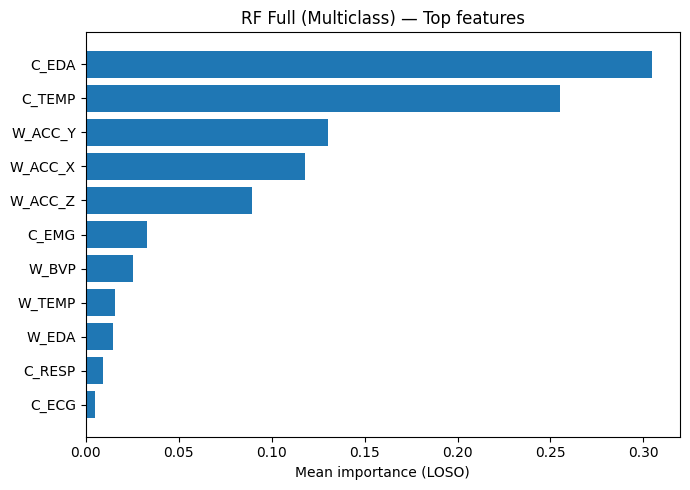

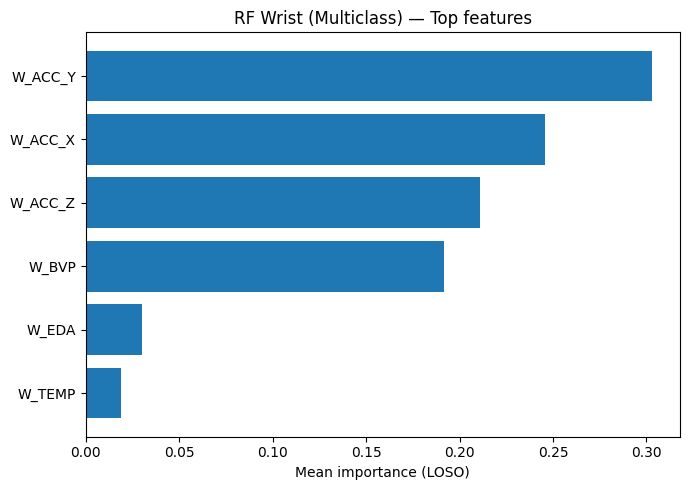

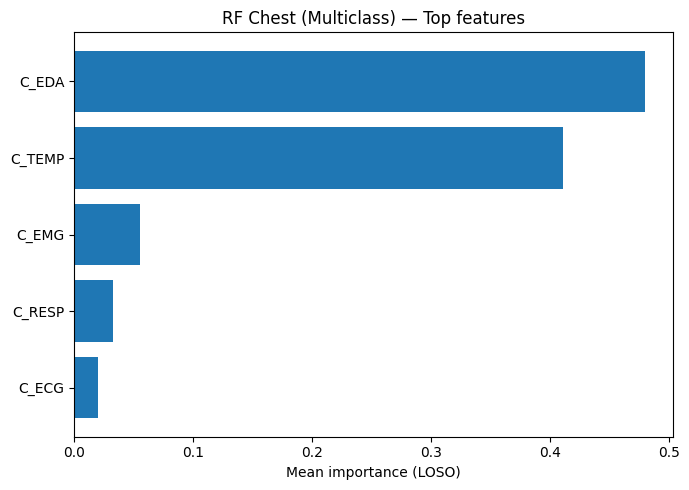


Top 15 — RF Full (Multiclass):
C_EDA      0.304447
C_TEMP     0.254913
W_ACC_Y    0.130439
W_ACC_X    0.117905
W_ACC_Z    0.089439
C_EMG      0.032770
W_BVP      0.025551
W_TEMP     0.015662
W_EDA      0.014703
C_RESP     0.009166
C_ECG      0.005004
dtype: float64

Top 15 — RF Wrist (Multiclass):
W_ACC_Y    0.302785
W_ACC_X    0.245734
W_ACC_Z    0.210789
W_BVP      0.191642
W_EDA      0.030010
W_TEMP     0.019040
dtype: float64

Top 15 — RF Chest (Multiclass):
C_EDA     0.479854
C_TEMP    0.411175
C_EMG     0.055438
C_RESP    0.033070
C_ECG     0.020463
dtype: float64


In [19]:
#MULTICLASS
imp_full_m  = mean_importances_over_loso_rf(X3_full,  y3, g3, FEATURES,   bp_full_m,
                                            title="RF Full (Multiclass) — Top features", top=15)
imp_wrist_m = mean_importances_over_loso_rf(X3_wrist, y3, g3, WRIST_COLS, bp_wrist_m,
                                            title="RF Wrist (Multiclass) — Top features", top=15)
imp_chest_m = mean_importances_over_loso_rf(X3_chest, y3, g3, CHEST_COLS, bp_chest_m,
                                            title="RF Chest (Multiclass) — Top features", top=15)

print("\nTop 15 — RF Full (Multiclass):")
print(imp_full_m.head(15))
print("\nTop 15 — RF Wrist (Multiclass):")
print(imp_wrist_m.head(15))
print("\nTop 15 — RF Chest (Multiclass):")
print(imp_chest_m.head(15))

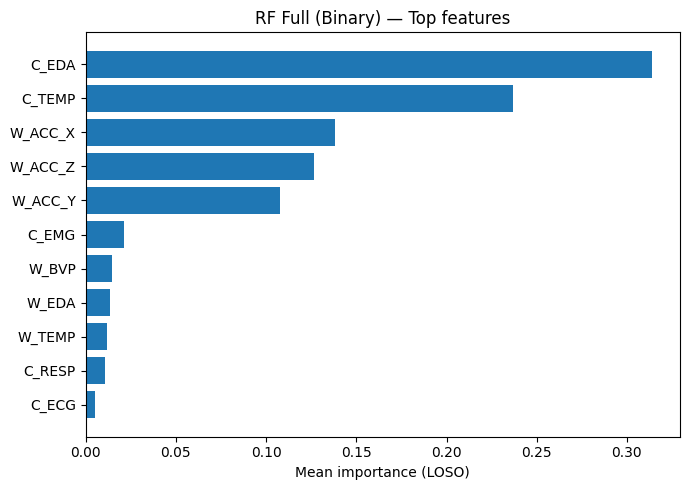

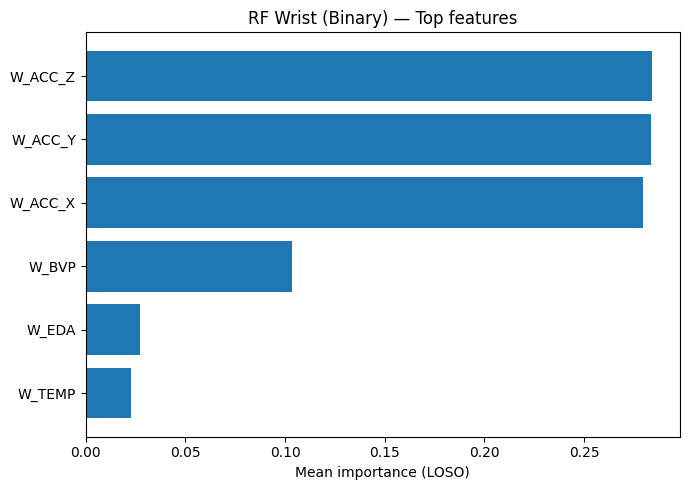

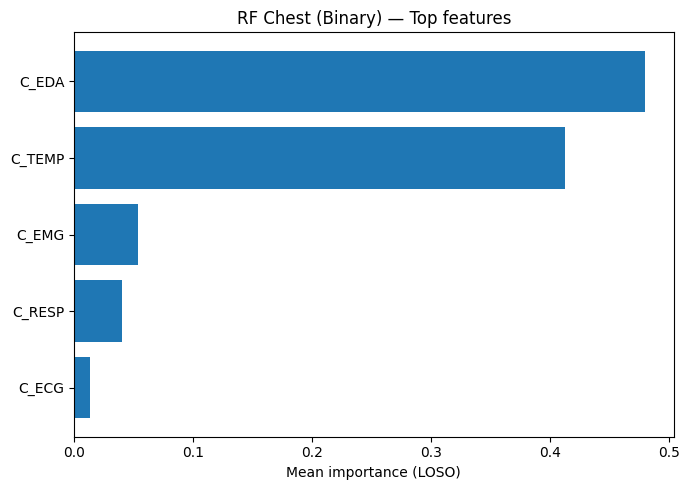

In [20]:
#BINARY
imp_full_b  = mean_importances_over_loso_rf(Xb_full,  yb, gb, FEATURES,   bp_full_b,
                                            title="RF Full (Binary) — Top features", top=15)
imp_wrist_b = mean_importances_over_loso_rf(Xb_wrist, yb, gb, WRIST_COLS, bp_wrist_b,
                                            title="RF Wrist (Binary) — Top features", top=15)
imp_chest_b = mean_importances_over_loso_rf(Xb_chest, yb, gb, CHEST_COLS, bp_chest_b,
                                            title="RF Chest (Binary) — Top features", top=15)
